In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
!pip install simpletransformers
from simpletransformers.classification import ClassificationModel, ClassificationArgs


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_tm/text-mining-project/data/original/total.csv', sep=",", error_bad_lines=False, encoding= "unicode_escape")
test_df = pd.read_csv('/content/drive/MyDrive/data_tm/text-mining-project/data/test/sentiment-topic-final-test.tsv', sep='\t', encoding='utf-8')

<ipython-input-37-8b4f8b4f79fe>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/content/drive/MyDrive/data_tm/text-mining-project/data/original/total.csv', sep=",", error_bad_lines=False, encoding= "unicode_escape")


## Conventional Machine Learning Approach: SVM

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
# vectorizer taken from previous labs setup
count_vectorizer = CountVectorizer(min_df=2, # If a token appears fewer times than this, across all documents, it will be ignored
                             tokenizer=nltk.word_tokenize, # we use the nltk tokenizer
                             stop_words=stopwords.words('english')) # stopwords are removed



counts = count_vectorizer.fit_transform(df['text'])

# TF-IDF
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(counts)

# split the data into train and dev
docs_train, docs_dev, y_train, y_dev = train_test_split(
    tfidf, # the tf-idf model
    df['topic'], # the labels
    test_size=0.1, # the size of the dev set
    random_state=0, # random seed
    )

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Omer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Omer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Omer\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [ ]:
# SVM classifier from sklearn

# train the model
svm = LinearSVC()
svm.fit(docs_train, y_train)

LinearSVC()

In [ ]:
# evaluate the model on the train set
y_pred = svm.predict(docs_train)

print('Classification report for train data')
print(classification_report(y_train, y_pred))

Classification report for train data
              precision    recall  f1-score   support

        book       1.00      1.00      1.00      2714
       movie       1.00      1.00      1.00      2693
  restaurant       1.00      1.00      1.00      2693

    accuracy                           1.00      8100
   macro avg       1.00      1.00      1.00      8100
weighted avg       1.00      1.00      1.00      8100



In [ ]:
# evaluate the model on the validation set
y_pred = svm.predict(docs_dev)

print('Classification report for validation data')
print(classification_report(y_dev, y_pred))

Classification report for validation data
              precision    recall  f1-score   support

        book       0.97      0.97      0.97       286
       movie       0.95      0.97      0.96       307
  restaurant       0.99      0.97      0.98       307

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



In [ ]:
# evaluate the model on the test set
docs_test = count_vectorizer.transform(test_data['text'])
docs_test = tfidf_transformer.transform(docs_test)

y_pred = svm.predict(docs_test)

print('Classification report for test data')
print(classification_report(test_data['topic'], y_pred))

Classification report for test data
              precision    recall  f1-score   support

        book       1.00      1.00      1.00         2
       movie       0.83      1.00      0.91         5
  restaurant       1.00      0.67      0.80         3

    accuracy                           0.90        10
   macro avg       0.94      0.89      0.90        10
weighted avg       0.92      0.90      0.89        10



# TRANSFORMER: ROBERTA

In [ ]:

train = df.rename(columns={'topic': 'labels'})
test = test_df.rename(columns={'topic': 'labels'})
test = test[['text', 'labels']]
train = train[['text', 'labels']]
train['labels'] = train['labels'].replace('book', 0)
train['labels'] = train['labels'].replace('restaurant', 1)
train['labels'] = train['labels'].replace('movie', 2)
test['labels'] = test['labels'].replace('book', 0)
test['labels'] = test['labels'].replace('restaurant', 1)
test['labels'] = test['labels'].replace('movie', 2)
train, dev = train_test_split(train, test_size=0.2, random_state=1, 
                               stratify=df[['topic']])


In [ ]:
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=128 # maximum sequence length

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)



In [ ]:
model_args.use_multiprocessing=False
model_args.use_multiprocessing_for_evaluation=False

In [ ]:
# set use_cuda = True when running on colab
model = ClassificationModel('roberta', 'roberta-base', num_labels=3, args=model_args, use_cuda=True)
# fine tuning on our dataset
_ , history = model.train_model(train, eval_df=dev)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/225 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/225 [00:00<?, ?it/s]

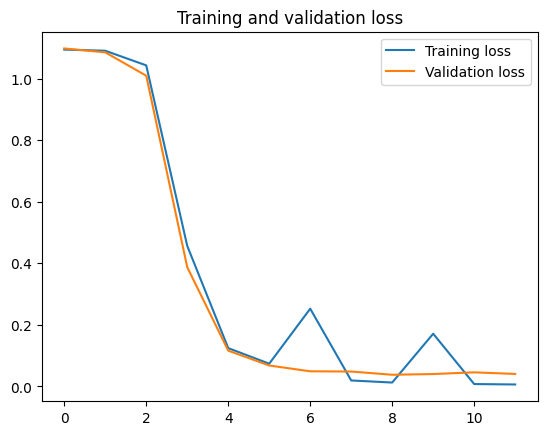

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sn 
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


In [ ]:
predicted, outputs = model.predict(dev['text'].to_list())
print('Classification report for validation data')
print(classification_report(dev.labels, predicted))


  0%|          | 0/225 [00:00<?, ?it/s]

Classification report for validation data
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       600
           1       0.99      0.99      0.99       600
           2       1.00      0.98      0.99       600

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



In [ ]:
predicted, outputs = model.predict(train['text'].to_list())
print('Classification report for train data')
print(classification_report(train.labels, predicted))

  0%|          | 0/900 [00:00<?, ?it/s]

Classification report for train data
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2400
           1       1.00      1.00      1.00      2400
           2       1.00      0.99      0.99      2400

    accuracy                           1.00      7200
   macro avg       1.00      1.00      1.00      7200
weighted avg       1.00      1.00      1.00      7200



In [ ]:
predicted, outputs = model.predict(test['text'].to_list())
print('Classification report for test data')
print(classification_report(test.labels, predicted))

  0%|          | 0/2 [00:00<?, ?it/s]

Classification report for test data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.67      0.80         3
           2       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.94      0.89      0.90        10
weighted avg       0.92      0.90      0.89        10



In [ ]:
test['correct'] = test.labels == predicted
test

,text,labels,correct
0,It took eight years for Warner Brothers to rec...,2,True
1,All the New York University students love this...,1,False
2,This Italian place is really trendy but they h...,1,True
3,"In conclusion, my review of this book would be...",0,True
4,The story of this movie is focused on Carl Bra...,2,True
5,Chris O'Donnell stated that while filming for ...,2,True
6,My husband and I moved to Amsterdam 6 years ag...,1,True
7,Dame Maggie Smith performed her role excellent...,2,True
8,The new movie by Mr. Kruno was shot in New Yor...,2,True
9,"I always have loved English novels, but I just...",0,True
